In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math

In [2]:
class EncoderLayer(nn.Module):
    """
    Represents one Encoder layer of the Transformer Encoder
    Refer Fig. 1 in https://arxiv.org/pdf/1706.03762.pdf
    NOTE: The layer normalization step has been moved to the input as per latest version of T2T
    """
    def __init__(self, hidden_size, total_key_depth, total_value_depth, filter_size, num_heads,
                 bias_mask=None, layer_dropout=0.0, attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            layer_dropout: Dropout for this layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(EncoderLayer, self).__init__()
        
        self.multi_head_attention = MultiHeadAttention(hidden_size, total_key_depth, total_value_depth, 
                                                       hidden_size, num_heads, bias_mask, attention_dropout)
        
        self.positionwise_feed_forward = PositionwiseFeedForward(hidden_size, filter_size, hidden_size,
                                                                 layer_config='cc', padding = 'both', 
                                                                 dropout=relu_dropout)
        self.dropout = nn.Dropout(layer_dropout)
        self.layer_norm_mha = LayerNorm(hidden_size)
        self.layer_norm_ffn = LayerNorm(hidden_size)
        
    def forward(self, inputs):
        x = inputs
        
        # Layer Normalization
        x_norm = self.layer_norm_mha(x)
        
        # Multi-head attention
        y = self.multi_head_attention(x_norm, x_norm, x_norm)
        
        # Dropout and residual
        x = self.dropout(x + y)
        
        # Layer Normalization
        x_norm = self.layer_norm_ffn(x)
        
        # Positionwise Feedforward
        y = self.positionwise_feed_forward(x_norm)
        
        # Dropout and residual
        y = self.dropout(x + y)
        
        return y

In [3]:
class DecoderLayer(nn.Module):
    """
    Represents one Decoder layer of the Transformer Decoder
    Refer Fig. 1 in https://arxiv.org/pdf/1706.03762.pdf
    NOTE: The layer normalization step has been moved to the input as per latest version of T2T
    """
    def __init__(self, hidden_size, total_key_depth, total_value_depth, filter_size, num_heads,
                 bias_mask, layer_dropout=0.0, attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            layer_dropout: Dropout for this layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(DecoderLayer, self).__init__()
        
        self.multi_head_attention_dec = MultiHeadAttention(hidden_size, total_key_depth, total_value_depth, 
                                                       hidden_size, num_heads, bias_mask, attention_dropout)

        self.multi_head_attention_enc_dec = MultiHeadAttention(hidden_size, total_key_depth, total_value_depth, 
                                                       hidden_size, num_heads, None, attention_dropout)
        
        self.positionwise_feed_forward = PositionwiseFeedForward(hidden_size, filter_size, hidden_size,
                                                                 layer_config='cc', padding = 'left', 
                                                                 dropout=relu_dropout)
        self.dropout = nn.Dropout(layer_dropout)
        self.layer_norm_mha_dec = LayerNorm(hidden_size)
        self.layer_norm_mha_enc = LayerNorm(hidden_size)
        self.layer_norm_ffn = LayerNorm(hidden_size)

        
    def forward(self, inputs):
        """
        NOTE: Inputs is a tuple consisting of decoder inputs and encoder output
        """
        x, encoder_outputs = inputs
        
        # Layer Normalization before decoder self attention
        x_norm = self.layer_norm_mha_dec(x)
        
        # Masked Multi-head attention
        y = self.multi_head_attention_dec(x_norm, x_norm, x_norm)
        
        # Dropout and residual after self-attention
        x = self.dropout(x + y)

        # Layer Normalization before encoder-decoder attention
        x_norm = self.layer_norm_mha_enc(x)

        # Multi-head encoder-decoder attention
        y = self.multi_head_attention_enc_dec(x_norm, encoder_outputs, encoder_outputs)
        
        # Dropout and residual after encoder-decoder attention
        x = self.dropout(x + y)
        
        # Layer Normalization
        x_norm = self.layer_norm_ffn(x)
        
        # Positionwise Feedforward
        y = self.positionwise_feed_forward(x_norm)
        
        # Dropout and residual after positionwise feed forward layer
        y = self.dropout(x + y)
        
        # Return encoder outputs as well to work with nn.Sequential
        return y, encoder_outputs

In [4]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention as per https://arxiv.org/pdf/1706.03762.pdf
    Refer Figure 2
    """
    def __init__(self, input_depth, total_key_depth, total_value_depth, output_depth, 
                 num_heads, bias_mask=None, dropout=0.0):
        """
        Parameters:
            input_depth: Size of last dimension of input
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            dropout: Dropout probability (Should be non-zero only during training)
        """
        super(MultiHeadAttention, self).__init__()
        # Checks borrowed from 
        # https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/layers/common_attention.py
        if total_key_depth % num_heads != 0:
            raise ValueError("Key depth (%d) must be divisible by the number of "
                             "attention heads (%d)." % (total_key_depth, num_heads))
        if total_value_depth % num_heads != 0:
            raise ValueError("Value depth (%d) must be divisible by the number of "
                             "attention heads (%d)." % (total_value_depth, num_heads))
            
        self.num_heads = num_heads
        self.query_scale = (total_key_depth//num_heads)**-0.5
        self.bias_mask = bias_mask
        
        # Key and query depth will be same
        self.query_linear = nn.Linear(input_depth, total_key_depth, bias=False)
        self.key_linear = nn.Linear(input_depth, total_key_depth, bias=False)
        self.value_linear = nn.Linear(input_depth, total_value_depth, bias=False)
        self.output_linear = nn.Linear(total_value_depth, output_depth, bias=False)
        
        self.dropout = nn.Dropout(dropout)
    
    def _split_heads(self, x):
        """
        Split x such to add an extra num_heads dimension
        Input:
            x: a Tensor with shape [batch_size, seq_length, depth]
        Returns:
            A Tensor with shape [batch_size, num_heads, seq_length, depth/num_heads]
        """
        if len(x.shape) != 3:
            raise ValueError("x must have rank 3")
        shape = x.shape
        return x.view(shape[0], shape[1], self.num_heads, shape[2]//self.num_heads).permute(0, 2, 1, 3)
    
    def _merge_heads(self, x):
        """
        Merge the extra num_heads into the last dimension
        Input:
            x: a Tensor with shape [batch_size, num_heads, seq_length, depth/num_heads]
        Returns:
            A Tensor with shape [batch_size, seq_length, depth]
        """
        if len(x.shape) != 4:
            raise ValueError("x must have rank 4")
        shape = x.shape
        return x.permute(0, 2, 1, 3).contiguous().view(shape[0], shape[2], shape[3]*self.num_heads)
        
    def forward(self, queries, keys, values, src_mask=None):
        
        # Do a linear for each component
        queries = self.query_linear(queries)
        keys = self.key_linear(keys)
        values = self.value_linear(values)
        
        # Split into multiple heads
        queries = self._split_heads(queries)
        keys = self._split_heads(keys)
        values = self._split_heads(values)
        
        # Scale queries
        queries *= self.query_scale
        
        # Combine queries and keys
        logits = torch.matmul(queries, keys.permute(0, 1, 3, 2))
        

        if src_mask is not None:
            logits = logits.masked_fill(src_mask, -np.inf)
            
        # Add bias to mask future values
        if self.bias_mask is not None:
            logits += self.bias_mask[:, :, :logits.shape[-2], :logits.shape[-1]].type_as(logits.data)
        
        # Convert to probabilites
        weights = nn.functional.softmax(logits, dim=-1)
        
        # Dropout
        weights = self.dropout(weights)
        
        # Combine with values to get context
        contexts = torch.matmul(weights, values)
        
        # Merge heads
        contexts = self._merge_heads(contexts)
        #contexts = torch.tanh(contexts)
        
        # Linear to get output
        outputs = self.output_linear(contexts)
        
        return outputs

In [5]:
class Conv(nn.Module):
    """
    Convenience class that does padding and convolution for inputs in the format
    [batch_size, sequence length, hidden size]
    """
    def __init__(self, input_size, output_size, kernel_size, pad_type):
        """
        Parameters:
            input_size: Input feature size
            output_size: Output feature size
            kernel_size: Kernel width
            pad_type: left -> pad on the left side (to mask future data), 
                      both -> pad on both sides
        """
        super(Conv, self).__init__()
        padding = (kernel_size - 1, 0) if pad_type == 'left' else (kernel_size//2, (kernel_size - 1)//2)
        self.pad = nn.ConstantPad1d(padding, 0)
        self.conv = nn.Conv1d(input_size, output_size, kernel_size=kernel_size, padding=0)

    def forward(self, inputs):
        inputs = self.pad(inputs.permute(0, 2, 1))
        outputs = self.conv(inputs).permute(0, 2, 1)

        return outputs

In [6]:
class PositionwiseFeedForward(nn.Module):
    """
    Does a Linear + RELU + Linear on each of the timesteps
    """
    def __init__(self, input_depth, filter_size, output_depth, layer_config='ll', padding='left', dropout=0.0):
        """
        Parameters:
            input_depth: Size of last dimension of input
            filter_size: Hidden size of the middle layer
            output_depth: Size last dimension of the final output
            layer_config: ll -> linear + ReLU + linear
                          cc -> conv + ReLU + conv etc.
            padding: left -> pad on the left side (to mask future data), 
                     both -> pad on both sides
            dropout: Dropout probability (Should be non-zero only during training)
        """
        super(PositionwiseFeedForward, self).__init__()
        
        layers = []
        sizes = ([(input_depth, filter_size)] + 
                 [(filter_size, filter_size)]*(len(layer_config)-2) + 
                 [(filter_size, output_depth)])

        for lc, s in zip(list(layer_config), sizes):
            if lc == 'l':
                layers.append(nn.Linear(*s))
            elif lc == 'c':
                layers.append(Conv(*s, kernel_size=3, pad_type=padding))
            else:
                raise ValueError("Unknown layer type {}".format(lc))

        self.layers = nn.ModuleList(layers)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inputs):
        x = inputs
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers):
                x = self.relu(x)
                x = self.dropout(x)

        return x


In [7]:
class LayerNorm(nn.Module):
    # Borrowed from jekbradbury
    # https://github.com/pytorch/pytorch/issues/1959
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


In [8]:
def _gen_bias_mask(max_length):
    """
    Generates bias values (-Inf) to mask future timesteps during attention
    """
    np_mask = np.triu(np.full([max_length, max_length], -np.inf), 1)
    torch_mask = torch.from_numpy(np_mask).type(torch.FloatTensor)
    
    return torch_mask.unsqueeze(0).unsqueeze(1)

In [9]:
def _gen_timing_signal(length, channels, min_timescale=1.0, max_timescale=1.0e4):
    """
    Generates a [1, length, channels] timing signal consisting of sinusoids
    Adapted from:
    https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/layers/common_attention.py
    """
    position = np.arange(length)
    num_timescales = channels // 2
    log_timescale_increment = ( math.log(float(max_timescale) / float(min_timescale)) / (float(num_timescales) - 1))
    inv_timescales = min_timescale * np.exp(np.arange(num_timescales).astype(np.float) * -log_timescale_increment)
    scaled_time = np.expand_dims(position, 1) * np.expand_dims(inv_timescales, 0)

    signal = np.concatenate([np.sin(scaled_time), np.cos(scaled_time)], axis=1)
    signal = np.pad(signal, [[0, 0], [0, channels % 2]], 
                    'constant', constant_values=[0.0, 0.0])
    signal =  signal.reshape([1, length, channels])

    return torch.from_numpy(signal).type(torch.FloatTensor)

In [10]:
class Encoder(nn.Module):
    """
    A Transformer Encoder module. 
    Inputs should be in the shape [batch_size, length, hidden_size]
    Outputs will have the shape [batch_size, length, hidden_size]
    Refer Fig.1 in https://arxiv.org/pdf/1706.03762.pdf
    """
    def __init__(self, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=100, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0, use_mask=False, act=True):
        """
        Parameters:
            hidden_size: Hidden size
            num_layers: Total layers in the Encoder
            num_heads: Number of attention heads
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            max_length: Max sequence length (required for timing signal)
            input_dropout: Dropout just after embedding
            layer_dropout: Dropout for each layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
            use_mask: Set to True to turn on future value masking
        """
        
        super(Encoder, self).__init__()
        
        self.timing_signal = _gen_timing_signal(max_length, hidden_size)
        ## for t
        self.position_signal = _gen_timing_signal(num_layers, hidden_size)

        self.num_layers = num_layers
        self.act = act
        params =(hidden_size, 
                 total_key_depth or hidden_size,
                 total_value_depth or hidden_size,
                 filter_size, 
                 num_heads, 
                 _gen_bias_mask(max_length) if use_mask else None,
                 layer_dropout, 
                 attention_dropout, 
                 relu_dropout)

        self.enc = EncoderLayer(*params)
        
        self.layer_norm = LayerNorm(hidden_size)
        self.input_dropout = nn.Dropout(input_dropout)
        if(self.act):
            self.act_fn = ACT_basic(hidden_size)

    def forward(self, inputs):

        #Add input dropout
        x = self.input_dropout(inputs)

        if(self.act):
            x, (remainders,n_updates) = self.act_fn(x, inputs, self.enc, self.timing_signal, self.position_signal, self.num_layers)
            return x, (remainders,n_updates)
        else:
            for l in range(self.num_layers):
                x += self.timing_signal[:, :inputs.shape[1], :].type_as(inputs.data)
                x += self.position_signal[:, l, :].unsqueeze(1).repeat(1,inputs.shape[1],1).type_as(inputs.data)
                x = self.enc(x)
            return x, None

In [11]:
class Decoder(nn.Module):
    """
    A Transformer Decoder module. 
    Inputs should be in the shape [batch_size, length, hidden_size]
    Outputs will have the shape [batch_size, length, hidden_size]
    Refer Fig.1 in https://arxiv.org/pdf/1706.03762.pdf
    """
    def __init__(self, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=100, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0, act=True):
        """
        Parameters:
            hidden_size: Hidden size
            num_layers: Total layers in the Encoder
            num_heads: Number of attention heads
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            max_length: Max sequence length (required for timing signal)
            input_dropout: Dropout just after embedding
            layer_dropout: Dropout for each layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(Decoder, self).__init__()
        
        self.timing_signal = _gen_timing_signal(max_length, hidden_size)
        self.position_signal = _gen_timing_signal(num_layers, hidden_size)
        self.num_layers = num_layers
        self.act = act
        params =(hidden_size, 
                 total_key_depth or hidden_size,
                 total_value_depth or hidden_size,
                 filter_size, 
                 num_heads, 
                 _gen_bias_mask(max_length), # mandatory
                 layer_dropout, 
                 attention_dropout, 
                 relu_dropout)

        self.dec = DecoderLayer(*params) 
        
        self.layer_norm = LayerNorm(hidden_size)
        self.input_dropout = nn.Dropout(input_dropout)
        if(self.act):
            self.act_fn = ACT_basic(hidden_size)
    
    def forward(self, inputs, encoder_output):
        #Add input dropout
        x = self.input_dropout(inputs)
        
        if(self.act):
            x, (remainders,n_updates) = self.act_fn(x, inputs, self.dec, self.timing_signal, self.position_signal, self.num_layers, encoder_output)
            return x, (remainders,n_updates)
        else:
            for l in range(self.num_layers):
                x += self.timing_signal[:, :inputs.shape[1], :].type_as(inputs.data)
                x += self.position_signal[:, l, :].unsqueeze(1).repeat(1,inputs.shape[1],1).type_as(inputs.data)
                x, _ = self.dec((x, encoder_output))
        return x, None

In [12]:
class ACT_basic(nn.Module):
    def __init__(self,hidden_size):
        super(ACT_basic, self).__init__()
        self.sigma = nn.Sigmoid()
        self.p = nn.Linear(hidden_size,1)  
        self.p.bias.data.fill_(1) 
        self.threshold = 1 - 0.1

    def forward(self, state, inputs, fn, time_enc, pos_enc, max_hop, encoder_output=None):
        # init_hdd
        ## [B, S]
        halting_probability = torch.zeros(inputs.shape[0],inputs.shape[1])
        ## [B, S
        remainders = torch.zeros(inputs.shape[0],inputs.shape[1])
        ## [B, S]
        n_updates = torch.zeros(inputs.shape[0],inputs.shape[1])
        ## [B, S, HDD]
        previous_state = torch.zeros_like(inputs)
        step = 0
        # for l in range(self.num_layers):
        while( ((halting_probability<self.threshold) & (n_updates < max_hop)).byte().any()):
            # Add timing signal
            state = state + time_enc[:, :inputs.shape[1], :].type_as(inputs.data)
            state = state + pos_enc[:, step, :].unsqueeze(1).repeat(1,inputs.shape[1],1).type_as(inputs.data)

            p = self.sigma(self.p(state)).squeeze(-1)
            # Mask for inputs which have not halted yet
            still_running = (halting_probability < 1.0).float()

            # Mask of inputs which halted at this step
            new_halted = (halting_probability + p * still_running > self.threshold).float() * still_running

            # Mask of inputs which haven't halted, and didn't halt this step
            still_running = (halting_probability + p * still_running <= self.threshold).float() * still_running

            # Add the halting probability for this step to the halting
            # probabilities for those input which haven't halted yet
            halting_probability = halting_probability + p * still_running

            # Compute remainders for the inputs which halted at this step
            remainders = remainders + new_halted * (1 - halting_probability)

            # Add the remainders to those inputs which halted at this step
            halting_probability = halting_probability + new_halted * remainders

            # Increment n_updates for all inputs which are still running
            n_updates = n_updates + still_running + new_halted

            # Compute the weight to be applied to the new state and output
            # 0 when the input has already halted
            # p when the input hasn't halted yet
            # the remainders when it halted this step
            update_weights = p * still_running + new_halted * remainders

            if encoder_output is not None:
                state, _ = fn((state, encoder_output))
            else:
                # apply transformation on the state
                state = fn(state)

            # update running part in the weighted state and keep the rest
            previous_state = ((state * update_weights.unsqueeze(-1)) + (previous_state * (1 - update_weights.unsqueeze(-1))))
            ## previous_state is actually the new_state at end of hte loop 
            ## to save a line I assigned to previous_state so in the next 
            ## iteration is correct. Notice that indeed we return previous_state
            step+=1
        return previous_state, (remainders,n_updates)

In [13]:
class BabiUTransformer(nn.Module):
    """
    A Transformer Module For BabI data. 
    Inputs should be in the shape story: [batch_size, memory_size, story_len ]
                                  query: [batch_size, 1, story_len]
    Outputs will have the shape [batch_size, ]
    """
    def __init__(self, output_size, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=71, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0, use_mask=False, act=True ):
        super(BabiUTransformer, self).__init__()

        self.transformer_enc = Encoder(hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                                filter_size, max_length=71, input_dropout=input_dropout, layer_dropout=layer_dropout, 
                                attention_dropout=attention_dropout, relu_dropout=relu_dropout, use_mask=False, act=act)
        
        self.transformer_dec = Decoder(hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                                filter_size, max_length=71, input_dropout=input_dropout, layer_dropout=layer_dropout, 
                                attention_dropout=attention_dropout, relu_dropout=relu_dropout, act=act)
        
        self.W = nn.Linear(hidden_size, output_size)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, story, trg):

        logit, act = self.transformer_enc(story)
        
        logit, act = self.transformer_dec(trg, logit)
        
        a_hat = self.W(torch.sum(logit,dim=1)/logit.size(1)) ## reduce mean

        return a_hat, self.softmax(a_hat), act


In [14]:
output_size = 1
hidden_size=20
total_key_depth=20
total_value_depth=20
filter_size=64
num_layers=2
num_heads=2
device = torch.device("cpu")

In [15]:
model = BabiUTransformer(
    output_size, 
    hidden_size, 
    num_layers, 
    num_heads, 
    total_key_depth, 
    total_value_depth,
    filter_size
).to(device)

<ipython-input-9-e41c5c72579e>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inv_timescales = min_timescale * np.exp(np.arange(num_timescales).astype(np.float) * -log_timescale_increment)


In [16]:
story = torch.rand(5,21,20).to(device)
trg = torch.rand(5,1,20).to(device)

In [17]:
output, softmax_output, act = model(story, trg)
print(output.shape)
print(output)

torch.Size([5, 1])
tensor([[2.4756],
        [2.3052],
        [2.4258],
        [2.4516],
        [1.9351]], grad_fn=<AddmmBackward0>)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [19]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)
input

,date,AOAL,AOAR,PITCH,W,MACH,AIRSPD,TEFLAPL,XIDA,T,...,OPR,OTL,OTR,VIBN1L,VIBN1R,VIBN2L,VIBN2R,FE,TMAX,FS
0,0,-10.55,-4.22,-0.53,63901.05853,0.084,56.3,5,6.855,20.50,...,24,110,110,0.03,0.05,0.05,0.05,23995.070700,24572.967483,577.896783
1,1,-9.84,-3.87,-0.53,63900.67347,0.087,58.2,5,6.325,20.50,...,26,110,110,0.03,0.05,0.07,0.05,23453.775200,24572.967483,1119.192283
2,2,-9.14,-3.34,-0.53,63900.23197,0.090,60.1,5,5.710,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22821.215600,24572.967483,1751.751883
3,3,-8.09,-3.87,-0.35,63899.73805,0.093,62.0,5,5.630,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22738.950900,24572.967483,1834.016583
4,4,-7.56,-3.87,-0.35,63899.14333,0.096,63.9,5,5.365,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22464.769900,24572.967483,2108.197583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11519,11544,-2.81,-3.69,-0.70,56378.87869,0.150,56.0,30,3.950,23.75,...,43,98,98,0.09,0.10,0.10,0.05,7668.487126,18764.344514,11095.857388
11520,11545,-2.99,-3.69,-0.88,56378.72144,0.150,52.0,30,4.220,23.75,...,31,98,98,0.10,0.10,0.12,0.07,7393.237132,18764.344514,11371.107383
11521,11546,-2.81,-3.69,-0.88,56378.57427,0.150,49.0,30,4.130,23.75,...,31,98,98,0.13,0.12,0.12,0.09,7484.958267,18764.344514,11279.386247
11522,11547,-2.81,-3.69,-0.70,56378.43517,0.150,46.0,30,3.950,24.00,...,31,97,97,0.13,0.15,0.18,0.09,7652.561590,18764.344514,11111.782924


In [20]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [21]:
df_for_training=df[feature_names].astype(float)

In [22]:
df_for_training.shape

(11524, 22)

In [23]:
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [24]:
trainX=[]
trainY=[]

In [25]:
n_future=1
n_past=20

In [26]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [27]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [28]:
trainX0=np.zeros((trainX.shape[0],22,20))
for i in range(0,trainX.shape[0]):
    trainX0[i]=trainX[i].T
trainX1=np.zeros((trainX.shape[0],21,20))
for i in range(0,trainX.shape[0]):
    trainX1[i]=trainX0[i][0:21,:]
trainX2=np.zeros((trainX.shape[0],1,20))
for i in range(0,trainX.shape[0]):
    trainX2[i]=trainX0[i][21,:]

In [29]:
trainX1_copy,trainX2_copy,trainY_copy=trainX1.copy(),trainX2.copy(),trainY.copy()

In [30]:
def random_shuffle(data1,data2,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data1)
    np.random.seed(randnum)
    np.random.shuffle(data2)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data1,data2,label

In [31]:
data1,data2,label=random_shuffle(trainX1,trainX2,trainY)

In [32]:
# Create a DataLoader for the training data
data1 = torch.from_numpy(data1).float()
data2 = torch.from_numpy(data2).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data1, data2, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [34]:
device = torch.device("cpu")

In [35]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data1, data2, targets) in enumerate(train_loader):
        data1 = data1.to(device=device)
        data2 = data2.to(device=device)
        targets = targets.to(device=device)
        output, softmax_output, act = model(data1, data2)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.8707776665687561
Epoch: 1 Loss: 0.5153623223304749
Epoch: 2 Loss: 0.22150419652462006
Epoch: 3 Loss: 0.24801096320152283
Epoch: 4 Loss: 0.26855260133743286
Epoch: 5 Loss: 0.41671696305274963
Epoch: 6 Loss: 0.21329233050346375
Epoch: 7 Loss: 0.25269508361816406
Epoch: 8 Loss: 0.7792965173721313
Epoch: 9 Loss: 0.17313677072525024
Epoch: 10 Loss: 0.23965366184711456
Epoch: 11 Loss: 0.28375306725502014
Epoch: 12 Loss: 0.18824946880340576
Epoch: 13 Loss: 0.17656490206718445
Epoch: 14 Loss: 0.15414538979530334
Epoch: 15 Loss: 0.1995580643415451
Epoch: 16 Loss: 0.1195724681019783
Epoch: 17 Loss: 0.2624056935310364
Epoch: 18 Loss: 0.29623740911483765
Epoch: 19 Loss: 0.5173407793045044
Epoch: 20 Loss: 1.1718512773513794
Epoch: 21 Loss: 0.159492626786232
Epoch: 22 Loss: 0.5606416463851929
Epoch: 23 Loss: 0.1670723408460617
Epoch: 24 Loss: 0.15085981786251068
Epoch: 25 Loss: 0.14129863679409027
Epoch: 26 Loss: 0.36852511763572693
Epoch: 27 Loss: 0.49810755252838135
Epoch: 28 Loss

Epoch: 227 Loss: 0.13556262850761414
Epoch: 228 Loss: 0.09909528493881226
Epoch: 229 Loss: 0.064229816198349
Epoch: 230 Loss: 0.1495615839958191
Epoch: 231 Loss: 0.058914996683597565
Epoch: 232 Loss: 0.17628857493400574
Epoch: 233 Loss: 0.05128460004925728
Epoch: 234 Loss: 0.08913946151733398
Epoch: 235 Loss: 0.2283710241317749
Epoch: 236 Loss: 0.09169875830411911
Epoch: 237 Loss: 0.04533898085355759
Epoch: 238 Loss: 0.034796714782714844
Epoch: 239 Loss: 0.10581258684396744
Epoch: 240 Loss: 0.13967357575893402
Epoch: 241 Loss: 0.2124941349029541
Epoch: 242 Loss: 0.168260857462883
Epoch: 243 Loss: 0.24842223525047302
Epoch: 244 Loss: 0.039437245577573776
Epoch: 245 Loss: 0.06837153434753418
Epoch: 246 Loss: 0.1559418886899948
Epoch: 247 Loss: 0.0752798393368721
Epoch: 248 Loss: 0.13927893340587616
Epoch: 249 Loss: 0.12437638640403748
Epoch: 250 Loss: 0.15231965482234955
Epoch: 251 Loss: 0.031248491257429123
Epoch: 252 Loss: 0.2511593997478485
Epoch: 253 Loss: 0.16973824799060822
Epoch: 

Epoch: 450 Loss: 0.09553972631692886
Epoch: 451 Loss: 0.11769156903028488
Epoch: 452 Loss: 0.10221253335475922
Epoch: 453 Loss: 0.22759518027305603
Epoch: 454 Loss: 0.0463564358651638
Epoch: 455 Loss: 0.06638109683990479
Epoch: 456 Loss: 0.09182591736316681
Epoch: 457 Loss: 0.09210270643234253
Epoch: 458 Loss: 0.04058297351002693
Epoch: 459 Loss: 0.042534321546554565
Epoch: 460 Loss: 0.15871891379356384
Epoch: 461 Loss: 0.09402558952569962
Epoch: 462 Loss: 0.11245298385620117
Epoch: 463 Loss: 0.08631699532270432
Epoch: 464 Loss: 0.07095561921596527
Epoch: 465 Loss: 0.10595575720071793
Epoch: 466 Loss: 0.0807187408208847
Epoch: 467 Loss: 0.12024405598640442
Epoch: 468 Loss: 0.10738971829414368
Epoch: 469 Loss: 0.08683272451162338
Epoch: 470 Loss: 0.06908650696277618
Epoch: 471 Loss: 0.04713210463523865
Epoch: 472 Loss: 0.1483391374349594
Epoch: 473 Loss: 0.11004261672496796
Epoch: 474 Loss: 0.08732333034276962
Epoch: 475 Loss: 0.13670217990875244
Epoch: 476 Loss: 0.048594605177640915
Ep

Epoch: 673 Loss: 0.12700465321540833
Epoch: 674 Loss: 0.08018980920314789
Epoch: 675 Loss: 0.0787205621600151
Epoch: 676 Loss: 0.07022200524806976
Epoch: 677 Loss: 0.08104786276817322
Epoch: 678 Loss: 0.09944100677967072
Epoch: 679 Loss: 0.10910830646753311
Epoch: 680 Loss: 0.03001442365348339
Epoch: 681 Loss: 0.0747494101524353
Epoch: 682 Loss: 0.04912266880273819
Epoch: 683 Loss: 0.03820906579494476
Epoch: 684 Loss: 0.0479331836104393
Epoch: 685 Loss: 0.13812239468097687
Epoch: 686 Loss: 0.030466679483652115
Epoch: 687 Loss: 0.031300317496061325
Epoch: 688 Loss: 0.07285693287849426
Epoch: 689 Loss: 0.14819321036338806
Epoch: 690 Loss: 0.16921958327293396
Epoch: 691 Loss: 0.0793631300330162
Epoch: 692 Loss: 0.2498241662979126
Epoch: 693 Loss: 0.09784191101789474
Epoch: 694 Loss: 0.09069713950157166
Epoch: 695 Loss: 0.03910824656486511
Epoch: 696 Loss: 0.04399564117193222
Epoch: 697 Loss: 0.10023383796215057
Epoch: 698 Loss: 0.06286782771348953
Epoch: 699 Loss: 0.1408727765083313
Epoch

Epoch: 896 Loss: 0.037370193749666214
Epoch: 897 Loss: 0.03595046326518059
Epoch: 898 Loss: 0.060763824731111526
Epoch: 899 Loss: 0.043596554547548294
Epoch: 900 Loss: 0.05010274797677994
Epoch: 901 Loss: 0.06744398921728134
Epoch: 902 Loss: 0.13258638978004456
Epoch: 903 Loss: 0.08572704344987869
Epoch: 904 Loss: 0.11622396111488342
Epoch: 905 Loss: 0.04900263994932175
Epoch: 906 Loss: 0.07985372841358185
Epoch: 907 Loss: 0.14130356907844543
Epoch: 908 Loss: 0.09542688727378845
Epoch: 909 Loss: 0.09432568401098251
Epoch: 910 Loss: 0.06024772673845291
Epoch: 911 Loss: 0.06881263107061386
Epoch: 912 Loss: 0.05720669403672218
Epoch: 913 Loss: 0.4340702295303345
Epoch: 914 Loss: 0.1647641658782959
Epoch: 915 Loss: 0.1608193814754486
Epoch: 916 Loss: 0.048379600048065186
Epoch: 917 Loss: 0.05211750417947769
Epoch: 918 Loss: 0.06424228847026825
Epoch: 919 Loss: 0.07632031291723251
Epoch: 920 Loss: 0.13429196178913116
Epoch: 921 Loss: 0.07581101357936859
Epoch: 922 Loss: 0.061526425182819366

In [36]:
test_data1 = torch.from_numpy(trainX1_copy).float()
test_data2 = torch.from_numpy(trainX2_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data1, test_data2, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [37]:
predictions=[]
for batch_idx, (data1, data2, targets) in enumerate(test_loader):
    data1 = data1.to(device=device)
    data2 = data2.to(device=device)
    output, softmax_output, act = model(data1,data2)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [38]:
predictions = np.array(predictions)

In [39]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [40]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

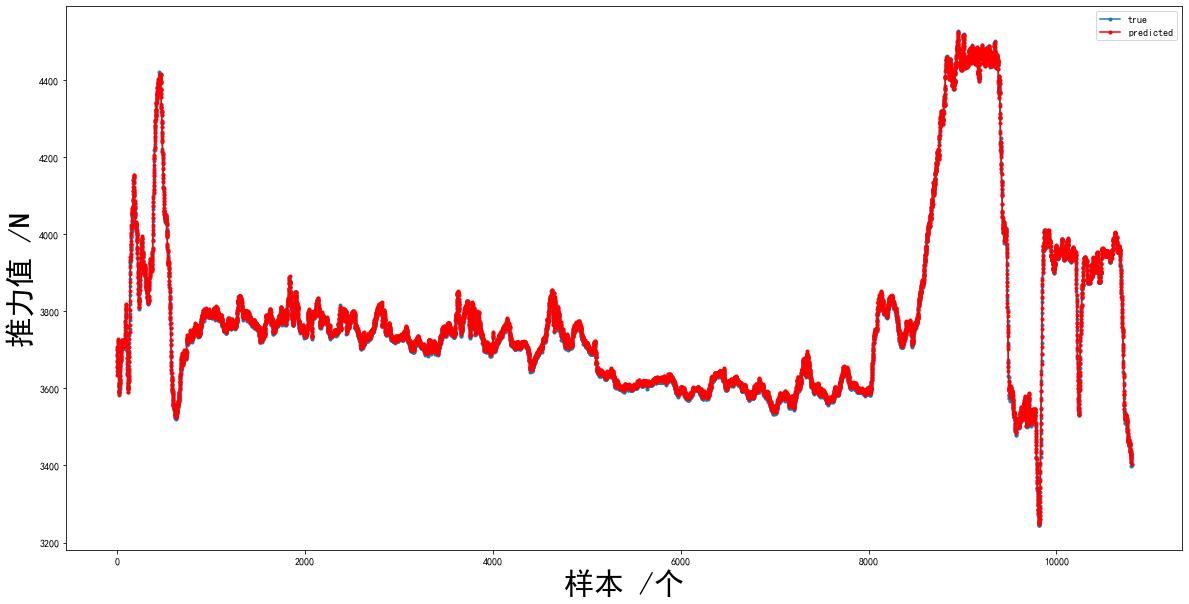

In [41]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();